In [1]:
! nvidia-smi

Fri Jun 30 13:24:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

!pip install torchsummary

!pip install tqdm

from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import utils
import model

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data
mean, std = utils.get_mean_and_std(exp_data)
exp.data.shape # train data shape

100%|██████████| 170498071/170498071 [00:02<00:00, 74998633.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


(50000, 32, 32, 3)

In [5]:
train_transforms = A.Compose([
    A.Normalize(
        mean=(0.49139968, 0.48215841, 0.44653091),
        std=(0.24703223, 0.24348513, 0.26158784),
    ),
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215841, 0.44653091), mask_fill_value=None)
])

test_transforms = A.Compose([
    A.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784],
    )
])

In [6]:
SEED = 69

torch.manual_seed(SEED)

batch_size=32

trainset = utils.Cifar10Dataset(root='./data', train=True, download=True, transform=train_transforms)
testset = utils.Cifar10Dataset(root='./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 3, 32, 32])
torch.Size([32])


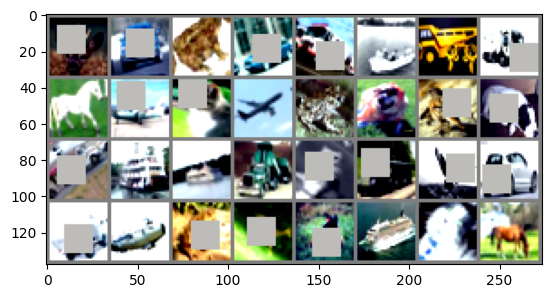

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
from model import Net
model = Net().to(device)

!pip install torchscan --no-deps
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

_______________________________________________________________________
Layer      Type          Output Shape        Param #    Receptive field
net        Net           (-1, 10)            0          1              
├─conv1    Sequential    (-1, 64, 16, 16)    56,867     7              
├─conv2    Sequential    (-1, 32, 9, 9)      50,530     15             
├─conv3    Sequential    (-1, 32, 4, 4)      57,890     39             
├─conv4    Sequential    (-1, 10, 6, 6)      19,905     71             
├─gap      Sequential    (-1, 10, 1, 1)      0          111            
Trainable params: 184,096
Non-trainable params: 0
Total params: 184,096
-----------------------------------------------------------------------
Model size (params + buffers): 0.71 Mb
Framework & CUDA overhead: 1054.27 Mb
Total RAM usage: 1054.98 Mb
-----------------------------------------------------------------------
Floating Point Operations on forward: 91.12 MFLOPs
Multiply-Accumulations on forward: 45.74 MMACs
Direc

/usr/local/lib/python3.10/dist-packages/torchscan/modules/flops.py:67: UserWarning: Module type not supported: Dropout2d
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/macs.py:50: UserWarning: Module type not supported: Dropout2d
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/memory.py:59: UserWarning: Module type not supported: Dropout2d
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")
/usr/local/lib/python3.10/dist-packages/torchscan/modules/receptive.py:55: UserWarning: Module type not supported: Dropout2d
  warnings.warn(f"Module type not supported: {module.__class__.__name__}")


In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


EPOCH: 1


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=2.3068575859069824 Batch_id=1562 Accuracy=31.37: 100%|██████████| 1563/1563 [00:37<00:00, 41.99it/s]



Test set: Average loss: 1.5088, Accuracy: 4463/10000 (44.63%)

EPOCH: 2


Loss=1.1069644689559937 Batch_id=1562 Accuracy=41.92: 100%|██████████| 1563/1563 [00:28<00:00, 54.85it/s]



Test set: Average loss: 1.2838, Accuracy: 5281/10000 (52.81%)

EPOCH: 3


Loss=1.4584133625030518 Batch_id=1562 Accuracy=46.83: 100%|██████████| 1563/1563 [00:26<00:00, 59.67it/s]



Test set: Average loss: 1.1207, Accuracy: 5961/10000 (59.61%)

EPOCH: 4


Loss=1.3571193218231201 Batch_id=1562 Accuracy=50.45: 100%|██████████| 1563/1563 [00:27<00:00, 57.35it/s]



Test set: Average loss: 1.0366, Accuracy: 6279/10000 (62.79%)

EPOCH: 5


Loss=1.69980788230896 Batch_id=1562 Accuracy=53.66: 100%|██████████| 1563/1563 [00:26<00:00, 59.77it/s]



Test set: Average loss: 0.9587, Accuracy: 6607/10000 (66.07%)

EPOCH: 6


Loss=0.844035804271698 Batch_id=1562 Accuracy=55.99: 100%|██████████| 1563/1563 [00:25<00:00, 60.12it/s]



Test set: Average loss: 0.9008, Accuracy: 6825/10000 (68.25%)

EPOCH: 7


Loss=1.0827302932739258 Batch_id=1562 Accuracy=57.59: 100%|██████████| 1563/1563 [00:26<00:00, 59.78it/s]



Test set: Average loss: 0.8705, Accuracy: 6917/10000 (69.17%)

EPOCH: 8


Loss=1.0583643913269043 Batch_id=1562 Accuracy=58.85: 100%|██████████| 1563/1563 [00:25<00:00, 60.16it/s]



Test set: Average loss: 0.8273, Accuracy: 7101/10000 (71.01%)

EPOCH: 9


Loss=1.5376560688018799 Batch_id=1562 Accuracy=60.05: 100%|██████████| 1563/1563 [00:26<00:00, 59.96it/s]



Test set: Average loss: 0.8209, Accuracy: 7101/10000 (71.01%)

EPOCH: 10


Loss=1.360754132270813 Batch_id=1562 Accuracy=60.83: 100%|██████████| 1563/1563 [00:26<00:00, 58.97it/s]



Test set: Average loss: 0.7480, Accuracy: 7391/10000 (73.91%)

EPOCH: 11


Loss=1.167781949043274 Batch_id=1562 Accuracy=61.83: 100%|██████████| 1563/1563 [00:26<00:00, 59.40it/s]



Test set: Average loss: 0.7491, Accuracy: 7409/10000 (74.09%)

EPOCH: 12


Loss=1.2041290998458862 Batch_id=1562 Accuracy=62.43: 100%|██████████| 1563/1563 [00:26<00:00, 59.96it/s]



Test set: Average loss: 0.7144, Accuracy: 7489/10000 (74.89%)

EPOCH: 13


Loss=0.8826513290405273 Batch_id=1562 Accuracy=63.44: 100%|██████████| 1563/1563 [00:26<00:00, 58.59it/s]



Test set: Average loss: 0.7008, Accuracy: 7554/10000 (75.54%)

EPOCH: 14


Loss=1.040178894996643 Batch_id=1562 Accuracy=63.96: 100%|██████████| 1563/1563 [00:26<00:00, 59.42it/s]



Test set: Average loss: 0.6761, Accuracy: 7678/10000 (76.78%)

EPOCH: 15


Loss=0.696320652961731 Batch_id=1562 Accuracy=64.26: 100%|██████████| 1563/1563 [00:26<00:00, 59.48it/s]



Test set: Average loss: 0.6649, Accuracy: 7718/10000 (77.18%)

EPOCH: 16


Loss=0.4678640067577362 Batch_id=1562 Accuracy=64.66: 100%|██████████| 1563/1563 [00:26<00:00, 59.65it/s]



Test set: Average loss: 0.6519, Accuracy: 7728/10000 (77.28%)

EPOCH: 17


Loss=1.0557903051376343 Batch_id=1562 Accuracy=65.13: 100%|██████████| 1563/1563 [00:26<00:00, 59.11it/s]



Test set: Average loss: 0.6422, Accuracy: 7765/10000 (77.65%)

EPOCH: 18


Loss=0.5169708132743835 Batch_id=1562 Accuracy=65.60: 100%|██████████| 1563/1563 [00:26<00:00, 59.72it/s]



Test set: Average loss: 0.6455, Accuracy: 7766/10000 (77.66%)

EPOCH: 19


Loss=0.672834038734436 Batch_id=1562 Accuracy=65.97: 100%|██████████| 1563/1563 [00:26<00:00, 59.47it/s]



Test set: Average loss: 0.6230, Accuracy: 7843/10000 (78.43%)

EPOCH: 20


Loss=0.9274170994758606 Batch_id=1562 Accuracy=66.21: 100%|██████████| 1563/1563 [00:25<00:00, 60.27it/s]



Test set: Average loss: 0.6451, Accuracy: 7744/10000 (77.44%)

EPOCH: 21


Loss=0.7302421927452087 Batch_id=1562 Accuracy=66.91: 100%|██████████| 1563/1563 [00:26<00:00, 59.88it/s]



Test set: Average loss: 0.6058, Accuracy: 7915/10000 (79.15%)

EPOCH: 22


Loss=0.9772884845733643 Batch_id=1562 Accuracy=67.21: 100%|██████████| 1563/1563 [00:26<00:00, 59.08it/s]



Test set: Average loss: 0.6252, Accuracy: 7843/10000 (78.43%)

EPOCH: 23


Loss=0.9988417029380798 Batch_id=1562 Accuracy=67.05: 100%|██████████| 1563/1563 [00:25<00:00, 60.30it/s]



Test set: Average loss: 0.5999, Accuracy: 7938/10000 (79.38%)

EPOCH: 24


Loss=0.9270927309989929 Batch_id=1562 Accuracy=67.64: 100%|██████████| 1563/1563 [00:26<00:00, 58.70it/s]



Test set: Average loss: 0.5942, Accuracy: 7960/10000 (79.60%)

EPOCH: 25


Loss=1.3957289457321167 Batch_id=1562 Accuracy=67.81: 100%|██████████| 1563/1563 [00:26<00:00, 59.29it/s]



Test set: Average loss: 0.5793, Accuracy: 7990/10000 (79.90%)

EPOCH: 26


Loss=2.054051637649536 Batch_id=1562 Accuracy=67.89: 100%|██████████| 1563/1563 [00:26<00:00, 58.82it/s]



Test set: Average loss: 0.5795, Accuracy: 7991/10000 (79.91%)

EPOCH: 27


Loss=0.7227762341499329 Batch_id=1562 Accuracy=68.38: 100%|██████████| 1563/1563 [00:26<00:00, 58.33it/s]



Test set: Average loss: 0.5810, Accuracy: 7990/10000 (79.90%)

EPOCH: 28


Loss=0.7345778942108154 Batch_id=1562 Accuracy=68.36: 100%|██████████| 1563/1563 [00:29<00:00, 53.47it/s]



Test set: Average loss: 0.5747, Accuracy: 8036/10000 (80.36%)

EPOCH: 29


Loss=1.0165048837661743 Batch_id=1562 Accuracy=68.89: 100%|██████████| 1563/1563 [00:26<00:00, 58.96it/s]



Test set: Average loss: 0.5843, Accuracy: 7976/10000 (79.76%)

EPOCH: 30


Loss=1.0796502828598022 Batch_id=1562 Accuracy=68.77: 100%|██████████| 1563/1563 [00:26<00:00, 59.10it/s]



Test set: Average loss: 0.5470, Accuracy: 8140/10000 (81.40%)

EPOCH: 31


Loss=1.1443846225738525 Batch_id=1562 Accuracy=69.27: 100%|██████████| 1563/1563 [00:26<00:00, 58.42it/s]



Test set: Average loss: 0.5699, Accuracy: 8031/10000 (80.31%)

EPOCH: 32


Loss=1.1273308992385864 Batch_id=1562 Accuracy=69.21: 100%|██████████| 1563/1563 [00:26<00:00, 58.94it/s]



Test set: Average loss: 0.5455, Accuracy: 8118/10000 (81.18%)

EPOCH: 33


Loss=0.7590397000312805 Batch_id=1562 Accuracy=69.55: 100%|██████████| 1563/1563 [00:26<00:00, 58.61it/s]



Test set: Average loss: 0.5323, Accuracy: 8198/10000 (81.98%)

EPOCH: 34


Loss=0.8844010829925537 Batch_id=1562 Accuracy=69.61: 100%|██████████| 1563/1563 [00:26<00:00, 58.48it/s]



Test set: Average loss: 0.5435, Accuracy: 8137/10000 (81.37%)

EPOCH: 35


Loss=1.087815761566162 Batch_id=1562 Accuracy=69.93: 100%|██████████| 1563/1563 [00:26<00:00, 58.41it/s]



Test set: Average loss: 0.5348, Accuracy: 8204/10000 (82.04%)

EPOCH: 36


Loss=1.4372144937515259 Batch_id=1562 Accuracy=69.64: 100%|██████████| 1563/1563 [00:26<00:00, 58.88it/s]



Test set: Average loss: 0.5361, Accuracy: 8153/10000 (81.53%)

EPOCH: 37


Loss=1.8342481851577759 Batch_id=1562 Accuracy=69.73: 100%|██████████| 1563/1563 [00:26<00:00, 58.37it/s]



Test set: Average loss: 0.5335, Accuracy: 8200/10000 (82.00%)

EPOCH: 38


Loss=1.2577829360961914 Batch_id=1562 Accuracy=69.86: 100%|██████████| 1563/1563 [00:27<00:00, 57.08it/s]



Test set: Average loss: 0.5682, Accuracy: 8050/10000 (80.50%)

EPOCH: 39


Loss=0.7611904144287109 Batch_id=1562 Accuracy=70.12: 100%|██████████| 1563/1563 [00:26<00:00, 58.15it/s]



Test set: Average loss: 0.5327, Accuracy: 8152/10000 (81.52%)

EPOCH: 40


Loss=0.6631705164909363 Batch_id=1562 Accuracy=70.59: 100%|██████████| 1563/1563 [00:26<00:00, 58.21it/s]



Test set: Average loss: 0.5203, Accuracy: 8210/10000 (82.10%)

EPOCH: 41


Loss=0.8851000070571899 Batch_id=1562 Accuracy=70.31: 100%|██████████| 1563/1563 [00:27<00:00, 57.65it/s]



Test set: Average loss: 0.5155, Accuracy: 8241/10000 (82.41%)

EPOCH: 42


Loss=1.0834764242172241 Batch_id=1562 Accuracy=70.69: 100%|██████████| 1563/1563 [00:27<00:00, 57.49it/s]



Test set: Average loss: 0.5230, Accuracy: 8191/10000 (81.91%)

EPOCH: 43


Loss=0.796375036239624 Batch_id=1562 Accuracy=70.81: 100%|██████████| 1563/1563 [00:27<00:00, 57.40it/s]



Test set: Average loss: 0.5173, Accuracy: 8218/10000 (82.18%)

EPOCH: 44


Loss=0.5985537171363831 Batch_id=1562 Accuracy=71.06: 100%|██████████| 1563/1563 [00:27<00:00, 57.25it/s]



Test set: Average loss: 0.5275, Accuracy: 8215/10000 (82.15%)

EPOCH: 45


Loss=0.2898034453392029 Batch_id=1562 Accuracy=70.96: 100%|██████████| 1563/1563 [00:27<00:00, 56.90it/s]



Test set: Average loss: 0.5103, Accuracy: 8247/10000 (82.47%)

EPOCH: 46


Loss=1.2856953144073486 Batch_id=1562 Accuracy=71.18: 100%|██████████| 1563/1563 [00:27<00:00, 57.46it/s]



Test set: Average loss: 0.5236, Accuracy: 8197/10000 (81.97%)

EPOCH: 47


Loss=0.5793033838272095 Batch_id=1562 Accuracy=71.25: 100%|██████████| 1563/1563 [00:27<00:00, 57.18it/s]



Test set: Average loss: 0.4959, Accuracy: 8296/10000 (82.96%)

EPOCH: 48


Loss=0.91966712474823 Batch_id=1562 Accuracy=71.22: 100%|██████████| 1563/1563 [00:27<00:00, 57.60it/s]



Test set: Average loss: 0.5079, Accuracy: 8270/10000 (82.70%)

EPOCH: 49


Loss=0.9598981142044067 Batch_id=1562 Accuracy=71.47: 100%|██████████| 1563/1563 [00:27<00:00, 57.24it/s]



Test set: Average loss: 0.5030, Accuracy: 8317/10000 (83.17%)

EPOCH: 50


Loss=0.6288504004478455 Batch_id=1562 Accuracy=71.69: 100%|██████████| 1563/1563 [00:27<00:00, 57.54it/s]



Test set: Average loss: 0.4941, Accuracy: 8291/10000 (82.91%)

EPOCH: 51


Loss=0.8799572587013245 Batch_id=1562 Accuracy=71.90: 100%|██████████| 1563/1563 [00:27<00:00, 56.97it/s]



Test set: Average loss: 0.5015, Accuracy: 8283/10000 (82.83%)

EPOCH: 52


Loss=1.1377966403961182 Batch_id=1562 Accuracy=71.92: 100%|██████████| 1563/1563 [00:27<00:00, 55.89it/s]



Test set: Average loss: 0.4865, Accuracy: 8325/10000 (83.25%)

EPOCH: 53


Loss=0.903238832950592 Batch_id=1562 Accuracy=71.92: 100%|██████████| 1563/1563 [00:27<00:00, 57.70it/s]



Test set: Average loss: 0.4872, Accuracy: 8325/10000 (83.25%)

EPOCH: 54


Loss=0.8262802362442017 Batch_id=1562 Accuracy=72.19: 100%|██████████| 1563/1563 [00:27<00:00, 57.30it/s]



Test set: Average loss: 0.4868, Accuracy: 8332/10000 (83.32%)

EPOCH: 55


Loss=0.7962016463279724 Batch_id=1562 Accuracy=71.86: 100%|██████████| 1563/1563 [00:27<00:00, 56.63it/s]



Test set: Average loss: 0.4894, Accuracy: 8333/10000 (83.33%)

EPOCH: 56


Loss=1.260438084602356 Batch_id=1562 Accuracy=72.04: 100%|██████████| 1563/1563 [00:27<00:00, 57.17it/s]



Test set: Average loss: 0.4846, Accuracy: 8332/10000 (83.32%)

EPOCH: 57


Loss=1.0954495668411255 Batch_id=1562 Accuracy=72.39: 100%|██████████| 1563/1563 [00:27<00:00, 57.07it/s]



Test set: Average loss: 0.5067, Accuracy: 8248/10000 (82.48%)

EPOCH: 58


Loss=0.6490752696990967 Batch_id=1562 Accuracy=72.55: 100%|██████████| 1563/1563 [00:27<00:00, 57.10it/s]



Test set: Average loss: 0.4837, Accuracy: 8370/10000 (83.70%)

EPOCH: 59


Loss=0.741668701171875 Batch_id=1562 Accuracy=72.32: 100%|██████████| 1563/1563 [00:27<00:00, 56.83it/s]



Test set: Average loss: 0.4728, Accuracy: 8350/10000 (83.50%)

EPOCH: 60


Loss=0.8099268674850464 Batch_id=1562 Accuracy=72.42: 100%|██████████| 1563/1563 [00:27<00:00, 56.94it/s]



Test set: Average loss: 0.4839, Accuracy: 8330/10000 (83.30%)

EPOCH: 61


Loss=1.1671116352081299 Batch_id=1562 Accuracy=72.57: 100%|██████████| 1563/1563 [00:28<00:00, 55.56it/s]



Test set: Average loss: 0.4669, Accuracy: 8406/10000 (84.06%)

EPOCH: 62


Loss=1.028230905532837 Batch_id=1562 Accuracy=72.71: 100%|██████████| 1563/1563 [00:27<00:00, 56.76it/s]



Test set: Average loss: 0.4714, Accuracy: 8370/10000 (83.70%)

EPOCH: 63


Loss=1.0605697631835938 Batch_id=1562 Accuracy=72.62: 100%|██████████| 1563/1563 [00:27<00:00, 57.27it/s]



Test set: Average loss: 0.4852, Accuracy: 8313/10000 (83.13%)

EPOCH: 64


Loss=1.3444421291351318 Batch_id=1562 Accuracy=72.86: 100%|██████████| 1563/1563 [00:27<00:00, 56.84it/s]



Test set: Average loss: 0.4706, Accuracy: 8377/10000 (83.77%)

EPOCH: 65


Loss=0.8443500995635986 Batch_id=1562 Accuracy=72.74: 100%|██████████| 1563/1563 [00:27<00:00, 56.50it/s]



Test set: Average loss: 0.4758, Accuracy: 8368/10000 (83.68%)

EPOCH: 66


Loss=0.3903438448905945 Batch_id=1562 Accuracy=72.93: 100%|██████████| 1563/1563 [00:27<00:00, 57.60it/s]



Test set: Average loss: 0.4725, Accuracy: 8358/10000 (83.58%)

EPOCH: 67


Loss=0.46998512744903564 Batch_id=1562 Accuracy=72.95: 100%|██████████| 1563/1563 [00:27<00:00, 57.20it/s]



Test set: Average loss: 0.4689, Accuracy: 8384/10000 (83.84%)

EPOCH: 68


Loss=0.7843579649925232 Batch_id=1562 Accuracy=73.08: 100%|██████████| 1563/1563 [00:27<00:00, 57.35it/s]



Test set: Average loss: 0.4679, Accuracy: 8415/10000 (84.15%)

EPOCH: 69


Loss=0.996626079082489 Batch_id=1562 Accuracy=72.99: 100%|██████████| 1563/1563 [00:27<00:00, 57.07it/s]



Test set: Average loss: 0.4508, Accuracy: 8449/10000 (84.49%)

EPOCH: 70


Loss=0.4608866274356842 Batch_id=1562 Accuracy=73.22: 100%|██████████| 1563/1563 [00:27<00:00, 57.21it/s]



Test set: Average loss: 0.4624, Accuracy: 8402/10000 (84.02%)

EPOCH: 71


Loss=1.0265134572982788 Batch_id=1562 Accuracy=73.04: 100%|██████████| 1563/1563 [00:27<00:00, 57.14it/s]



Test set: Average loss: 0.4574, Accuracy: 8454/10000 (84.54%)

EPOCH: 72


Loss=0.6729307174682617 Batch_id=1562 Accuracy=73.26: 100%|██████████| 1563/1563 [00:27<00:00, 56.13it/s]



Test set: Average loss: 0.4612, Accuracy: 8402/10000 (84.02%)

EPOCH: 73


Loss=0.7532056570053101 Batch_id=1562 Accuracy=73.02: 100%|██████████| 1563/1563 [00:27<00:00, 56.37it/s]



Test set: Average loss: 0.4604, Accuracy: 8427/10000 (84.27%)

EPOCH: 74


Loss=0.3873212933540344 Batch_id=1562 Accuracy=73.44: 100%|██████████| 1563/1563 [00:27<00:00, 57.33it/s]



Test set: Average loss: 0.4676, Accuracy: 8394/10000 (83.94%)

EPOCH: 75


Loss=0.6170775890350342 Batch_id=1562 Accuracy=73.61: 100%|██████████| 1563/1563 [00:27<00:00, 56.37it/s]



Test set: Average loss: 0.4605, Accuracy: 8419/10000 (84.19%)

EPOCH: 76


Loss=0.9261496663093567 Batch_id=1562 Accuracy=73.23: 100%|██████████| 1563/1563 [00:27<00:00, 56.01it/s]



Test set: Average loss: 0.4559, Accuracy: 8441/10000 (84.41%)

EPOCH: 77


Loss=0.8750383853912354 Batch_id=1562 Accuracy=73.60: 100%|██████████| 1563/1563 [00:27<00:00, 55.88it/s]



Test set: Average loss: 0.4582, Accuracy: 8435/10000 (84.35%)

EPOCH: 78


Loss=0.790626049041748 Batch_id=1562 Accuracy=73.80: 100%|██████████| 1563/1563 [00:28<00:00, 55.71it/s]



Test set: Average loss: 0.4691, Accuracy: 8385/10000 (83.85%)

EPOCH: 79


Loss=0.6412608027458191 Batch_id=1562 Accuracy=73.51: 100%|██████████| 1563/1563 [00:27<00:00, 55.91it/s]



Test set: Average loss: 0.4520, Accuracy: 8427/10000 (84.27%)

EPOCH: 80


Loss=1.19203782081604 Batch_id=1562 Accuracy=73.55: 100%|██████████| 1563/1563 [00:28<00:00, 55.49it/s]



Test set: Average loss: 0.4492, Accuracy: 8459/10000 (84.59%)

EPOCH: 81


Loss=1.270001769065857 Batch_id=1562 Accuracy=73.74: 100%|██████████| 1563/1563 [00:28<00:00, 55.46it/s]



Test set: Average loss: 0.4498, Accuracy: 8469/10000 (84.69%)

EPOCH: 82


Loss=1.050146460533142 Batch_id=1562 Accuracy=73.78: 100%|██████████| 1563/1563 [00:28<00:00, 54.76it/s]



Test set: Average loss: 0.4492, Accuracy: 8461/10000 (84.61%)

EPOCH: 83


Loss=1.1143254041671753 Batch_id=1562 Accuracy=74.13: 100%|██████████| 1563/1563 [00:28<00:00, 54.42it/s]



Test set: Average loss: 0.4408, Accuracy: 8481/10000 (84.81%)

EPOCH: 84


Loss=0.9308004975318909 Batch_id=1562 Accuracy=74.20: 100%|██████████| 1563/1563 [00:28<00:00, 54.45it/s]



Test set: Average loss: 0.4563, Accuracy: 8445/10000 (84.45%)

EPOCH: 85


Loss=0.984909176826477 Batch_id=1562 Accuracy=73.82: 100%|██████████| 1563/1563 [00:28<00:00, 55.23it/s]



Test set: Average loss: 0.4657, Accuracy: 8419/10000 (84.19%)

EPOCH: 86


Loss=0.49572983384132385 Batch_id=1562 Accuracy=73.85: 100%|██████████| 1563/1563 [00:28<00:00, 54.84it/s]



Test set: Average loss: 0.4434, Accuracy: 8483/10000 (84.83%)

EPOCH: 87


Loss=1.259509801864624 Batch_id=1562 Accuracy=74.36: 100%|██████████| 1563/1563 [00:28<00:00, 55.28it/s]



Test set: Average loss: 0.4432, Accuracy: 8458/10000 (84.58%)

EPOCH: 88


Loss=1.0339901447296143 Batch_id=1562 Accuracy=74.25: 100%|██████████| 1563/1563 [00:29<00:00, 52.92it/s]



Test set: Average loss: 0.4393, Accuracy: 8503/10000 (85.03%)

EPOCH: 89


Loss=0.6067336797714233 Batch_id=1562 Accuracy=74.26: 100%|██████████| 1563/1563 [00:28<00:00, 54.57it/s]



Test set: Average loss: 0.4336, Accuracy: 8510/10000 (85.10%)

EPOCH: 90


Loss=0.7043817043304443 Batch_id=1562 Accuracy=74.19: 100%|██████████| 1563/1563 [00:28<00:00, 55.10it/s]



Test set: Average loss: 0.4529, Accuracy: 8468/10000 (84.68%)

EPOCH: 91


Loss=0.8446559309959412 Batch_id=1562 Accuracy=74.36: 100%|██████████| 1563/1563 [00:29<00:00, 52.50it/s]



Test set: Average loss: 0.4396, Accuracy: 8514/10000 (85.14%)

EPOCH: 92


Loss=0.7737276554107666 Batch_id=1562 Accuracy=74.16: 100%|██████████| 1563/1563 [00:28<00:00, 54.36it/s]



Test set: Average loss: 0.4380, Accuracy: 8479/10000 (84.79%)

EPOCH: 93


Loss=0.7853014469146729 Batch_id=1562 Accuracy=74.18: 100%|██████████| 1563/1563 [00:28<00:00, 55.07it/s]



Test set: Average loss: 0.4498, Accuracy: 8454/10000 (84.54%)

EPOCH: 94


Loss=0.5694848895072937 Batch_id=1562 Accuracy=74.32: 100%|██████████| 1563/1563 [00:29<00:00, 53.21it/s]



Test set: Average loss: 0.4295, Accuracy: 8520/10000 (85.20%)

EPOCH: 95


Loss=1.2061861753463745 Batch_id=1562 Accuracy=74.42: 100%|██████████| 1563/1563 [00:28<00:00, 55.04it/s]



Test set: Average loss: 0.4359, Accuracy: 8510/10000 (85.10%)

EPOCH: 96


Loss=0.8461686372756958 Batch_id=1562 Accuracy=74.24: 100%|██████████| 1563/1563 [00:29<00:00, 53.45it/s]



Test set: Average loss: 0.4636, Accuracy: 8399/10000 (83.99%)

EPOCH: 97


Loss=0.6042918562889099 Batch_id=1562 Accuracy=74.52: 100%|██████████| 1563/1563 [00:29<00:00, 52.72it/s]



Test set: Average loss: 0.4442, Accuracy: 8475/10000 (84.75%)

EPOCH: 98


Loss=0.316726952791214 Batch_id=1562 Accuracy=74.79: 100%|██████████| 1563/1563 [00:29<00:00, 53.80it/s]



Test set: Average loss: 0.4334, Accuracy: 8509/10000 (85.09%)

EPOCH: 99


Loss=0.4103691577911377 Batch_id=1562 Accuracy=74.50: 100%|██████████| 1563/1563 [00:29<00:00, 53.81it/s]



Test set: Average loss: 0.4365, Accuracy: 8515/10000 (85.15%)

EPOCH: 100


Loss=1.0540934801101685 Batch_id=1562 Accuracy=74.57: 100%|██████████| 1563/1563 [00:29<00:00, 52.48it/s]



Test set: Average loss: 0.4418, Accuracy: 8484/10000 (84.84%)



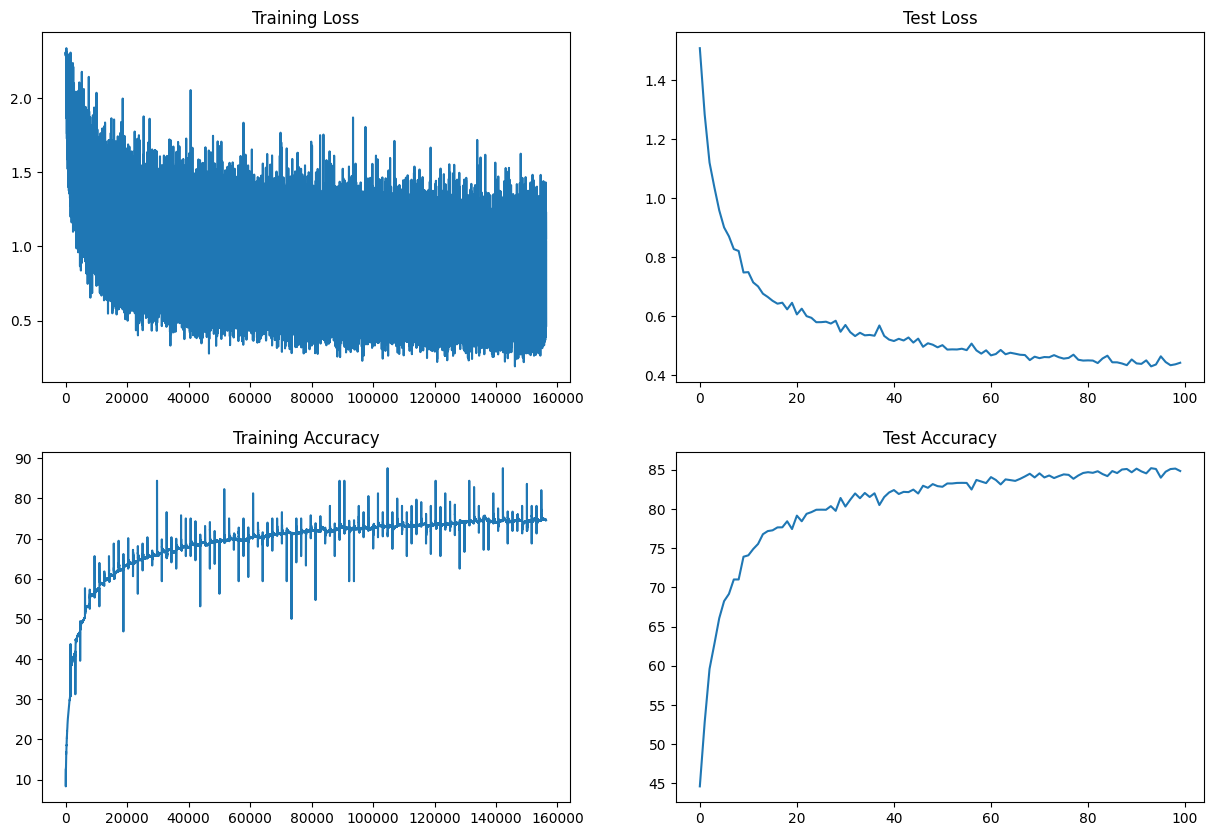

In [11]:
utils.draw_graphs(train_losses, train_acc, test_losses, test_acc)

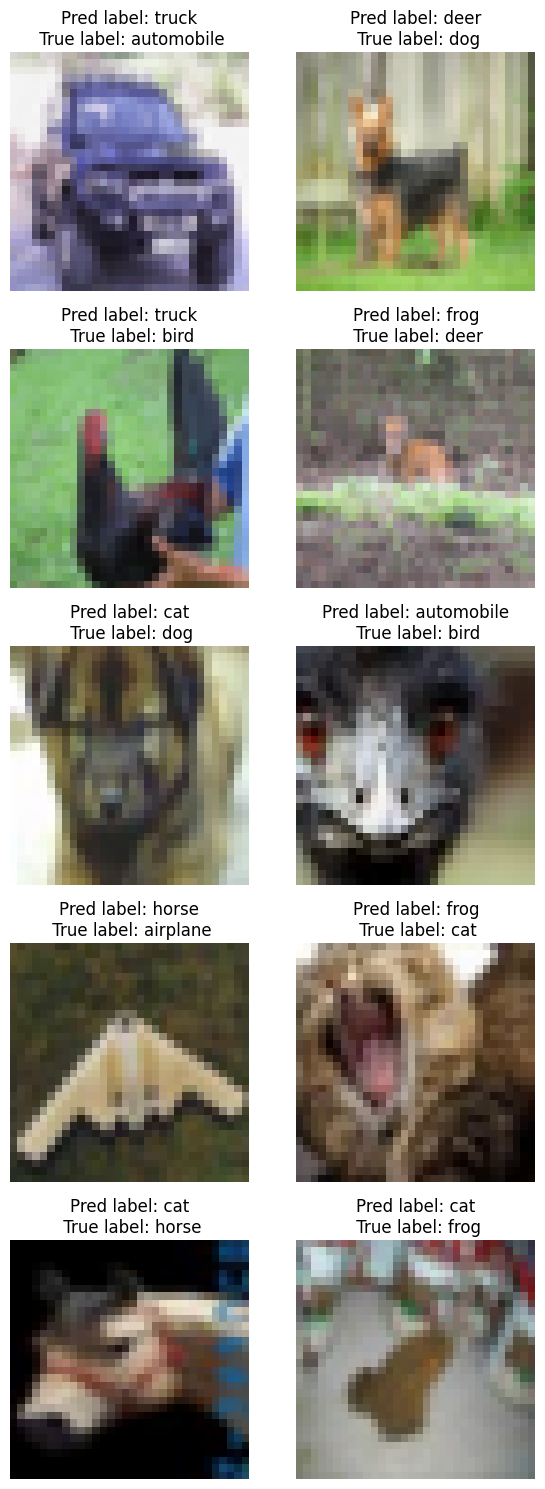

In [12]:
misclf = utils.plot_misclassified(model, test_loader, testset.classes, device, mean, std, no_misclf=10, plot_size=(5,2), return_misclf=True)

In [13]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

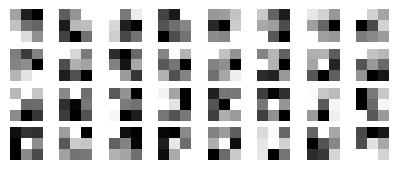

In [14]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()